In [1]:
from pathlib import Path

IMAGE_DIR = Path("data/forest_segmented/images")
MASK_DIR = Path("data/forest_segmented/masks")

In [2]:
import cv2
def read_image_label(image_name, mask_name):
    return cv2.imread(IMAGE_DIR / image_name), cv2.imread(MASK_DIR / mask_name)

In [3]:
import pandas as pd

metadata = pd.read_csv("data/forest_segmented/meta_data.csv")

In [8]:
from urllib import request

import detectree as dtr
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot
from img_processing import close_mask_clusters

def detectree_predict_plot(metadata_row, d, c, o):
    image_path, mask_path = IMAGE_DIR / metadata_row['image'], MASK_DIR / metadata_row['mask']
    y_pred = dtr.Classifier().predict_img(image_path)
    mask = close_mask_clusters(y_pred, d, c, o)

    # side-by-side plot of the tile and the predicted tree/non-tree pixels
    figwidth, figheight = plt.rcParams["figure.figsize"]
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
    with rio.open(image_path) as src:
        plot.show(src, ax=axes[0])
    axes[1].imshow(mask)

/home/janfidor/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/janfidor/anaconda3/envs/generative_playground/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/janfidor/anaconda3/envs/generative_playground/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


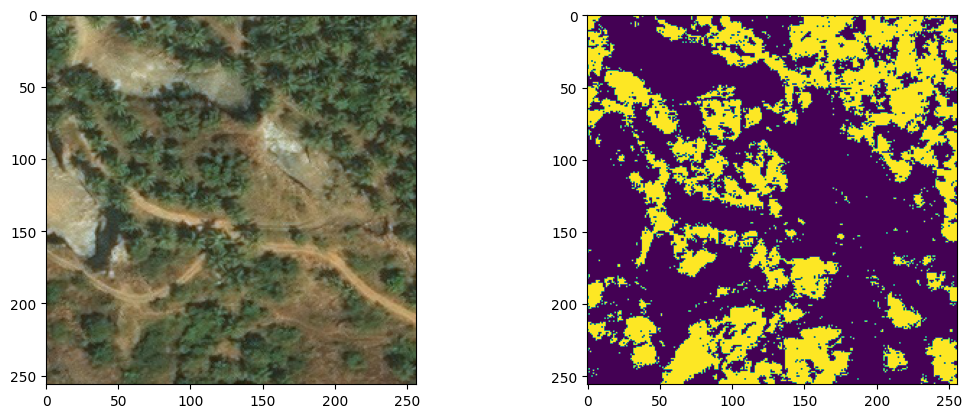

In [9]:
detectree_predict_plot(metadata.iloc[3], 1, 1, 1)

/home/janfidor/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/janfidor/anaconda3/envs/generative_playground/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


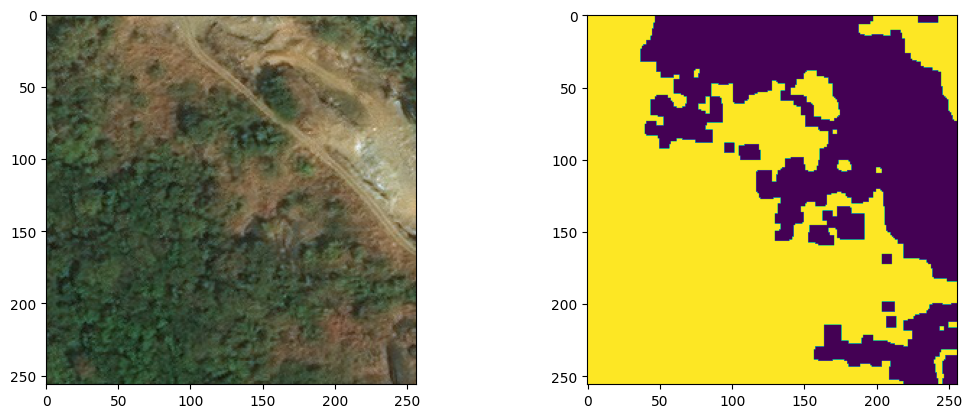

In [11]:
detectree_predict_plot(metadata.iloc[2], 3, 5, 5)

In [27]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "weights/sam2_hiera_base_plus.pt"
model_cfg = "sam2_hiera_b+.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device='cuda', apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [35]:
import cv2
import supervision as sv

def sam2_predict_plot(metadata_row):
    image_path = IMAGE_DIR / metadata_row['image']


    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)

    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    detections = sv.Detections.from_sam(sam_result=masks)
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    
    figwidth, figheight = plt.rcParams["figure.figsize"]
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
    with rio.open(image_path) as src:
        plot.show(src, ax=axes[0])
    axes[1].imshow(annotated_image)